In [17]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from torchvision.transforms import functional as F
from sklearn.metrics import classification_report

from vit_pytorch.vit import ViT, Transformer

### Ustawienia treningu

In [18]:
batch_size = 32
epochs = 100
lr = 3e-5
gamma = 0.9
seed = 100

In [19]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [20]:
device = 'cuda'

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 1.3 GB
Cached:    6.8 GB


In [22]:
data_dir = r'C:\Users\Jan\SGH\magisterka\dane\brain_tumor_mri_cropped'
base_dataset = datasets.ImageFolder(root=data_dir)

In [23]:
num_classes = len(base_dataset.classes)

In [24]:
num_total = len(base_dataset)
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)
num_test = num_total - num_train - num_val  


In [25]:
# Podział indeksów datasetu na treningowy, walidacyjny i testowy
indices = torch.randperm(len(base_dataset)).tolist()
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train + num_val]
test_indices = indices[num_train + num_val:]

# Utworzenie podzbiorów z odpowiednimi indeksami
train_dataset = Subset(base_dataset, train_indices)
val_dataset = Subset(base_dataset, val_indices)
test_dataset = Subset(base_dataset, test_indices)

In [26]:
# Transformacje dla zbioru treningowego
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [27]:
# Funkcje collate_fn dla każdego z zestawów danych
def train_collate_fn(batch):
    processed_batch = [(train_transform(x[0]), x[1]) for x in batch]
    return torch.utils.data.dataloader.default_collate(processed_batch)

def val_collate_fn(batch):
    processed_batch = [(val_transform(x[0]), x[1]) for x in batch]
    return torch.utils.data.dataloader.default_collate(processed_batch)

def test_collate_fn(batch):
    processed_batch = [(test_transform(x[0]), x[1]) for x in batch]
    return torch.utils.data.dataloader.default_collate(processed_batch)

# Utworzenie DataLoaderów z odpowiednimi transformacjami
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_collate_fn)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_collate_fn)

In [28]:
model = ViT(
    dim=768,
    image_size=224,
    patch_size=16,
    num_classes=num_classes,
    pool='cls',
    channels=3,
    emb_dropout=0.1,
    depth=12,
    heads=12,
    dim_head=64,
    mlp_dim=3072,
    dropout=0.1
).to(device)

In [29]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [30]:
import time
import torch

def train_model_with_timing(train_loader, valid_loader, model, criterion, optimizer, epochs, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_accuracy = 0
    best_model = None

    training_start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
        epoch_loss = 0
        epoch_accuracy = 0
        total_train = 0
        correct_train = 0

        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output, 1)
            total_train += label.size(0)
            correct_train += (predicted == label).sum().item()
            epoch_loss += loss.item()
        
        epoch_accuracy = 100 * correct_train / total_train
        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(epoch_accuracy)

        model.eval()
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        total_val = 0
        correct_val = 0

        with torch.no_grad():
            for data, label in valid_loader:
                data, label = data.to(device), label.to(device)
                val_output = model(data)
                val_loss = criterion(val_output, label)
                _, predicted = torch.max(val_output, 1)
                total_val += label.size(0)
                correct_val += (predicted == label).sum().item()
                epoch_val_loss += val_loss.item()
            
        epoch_val_accuracy = 100 * correct_val / total_val
        val_losses.append(epoch_val_loss / len(valid_loader))
        val_accuracies.append(epoch_val_accuracy)

        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            best_model = model.state_dict()

        epoch_end_time = time.time()
        print(f"Epoka {epoch+1}/{epochs} - Strata: {epoch_loss:.4f}, Dokładność: {epoch_accuracy:.2f}%, "
              f"Strata walidacyjna: {epoch_val_loss:.4f}, Dokładność walidacyjna: {epoch_val_accuracy:.2f}%, "
              f"Czas trwania epoki: {epoch_end_time - epoch_start_time:.2f}s")

    training_end_time = time.time()
    print(f"Całkowity czas treningu: {training_end_time - training_start_time:.2f}s")

    if best_model is not None:
        model.load_state_dict(best_model)

    history = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
    }

    return model, history

In [31]:
model, history = train_model_with_timing(train_loader, valid_loader, model, criterion, optimizer, epochs, device)

Epoka 1/100 - Strata: 243.0042, Dokładność: 32.72%, Strata walidacyjna: 30.0443, Dokładność walidacyjna: 44.87%, Czas trwania epoki: 69.90s
Epoka 2/100 - Strata: 221.9558, Dokładność: 42.83%, Strata walidacyjna: 24.4324, Dokładność walidacyjna: 52.56%, Czas trwania epoki: 69.99s
Epoka 3/100 - Strata: 206.9829, Dokładność: 48.33%, Strata walidacyjna: 22.0741, Dokładność walidacyjna: 56.13%, Czas trwania epoki: 70.45s
Epoka 4/100 - Strata: 185.8567, Dokładność: 55.38%, Strata walidacyjna: 16.9493, Dokładność walidacyjna: 70.51%, Czas trwania epoki: 70.54s
Epoka 5/100 - Strata: 180.2030, Dokładność: 56.35%, Strata walidacyjna: 16.3021, Dokładność walidacyjna: 70.37%, Czas trwania epoki: 70.44s
Epoka 6/100 - Strata: 166.0538, Dokładność: 61.37%, Strata walidacyjna: 14.6339, Dokładność walidacyjna: 75.64%, Czas trwania epoki: 70.59s
Epoka 7/100 - Strata: 159.4939, Dokładność: 62.94%, Strata walidacyjna: 14.9976, Dokładność walidacyjna: 71.51%, Czas trwania epoki: 70.50s
Epoka 8/100 - Strata

In [32]:
def evaluate_model(model, test_loader, device):
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=test_loader.dataset.dataset.classes)
    print(report)

In [33]:
evaluate_model(model, test_loader, device)

              precision    recall  f1-score   support

      glioma       0.94      0.85      0.89       155
  meningioma       0.70      0.76      0.73       174
     notumor       0.87      0.93      0.90       213
   pituitary       0.85      0.78      0.81       161

    accuracy                           0.83       703
   macro avg       0.84      0.83      0.83       703
weighted avg       0.84      0.83      0.83       703



In [34]:
import matplotlib.pyplot as plt
import numpy as np

def show_loss_accuracy_plots_with_timing(history):
    tr_acc = history['train_accuracies']
    tr_loss = history['train_losses']
    val_acc = history['val_accuracies']
    val_loss = history['val_losses']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = range(1, len(tr_acc) + 1)
    loss_label = f'Najlepsza epoka (strata) = {index_loss + 1}'
    acc_label = f'Najlepsza epoka (dokładność) = {index_acc + 1}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r-', label='Zbiór uczący - strata')
    plt.plot(Epochs, val_loss, 'g-', label='Zbiór walidacyjny - strata')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Funkcja straty dla zbioru uczącego oraz walidacyjnego')
    plt.xlabel('Epoki')
    plt.ylabel('Strata')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r-', label='Dokładność zbioru uczącego')
    plt.plot(Epochs, val_acc, 'g-', label='Dokładność zbioru walidacyjnego')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Dokładność dla zbioru uczącego oraz walidacyjnego')
    plt.xlabel('Epoki')
    plt.ylabel('Dokładność [%]')
    plt.legend()

    plt.tight_layout()
    plt.show()

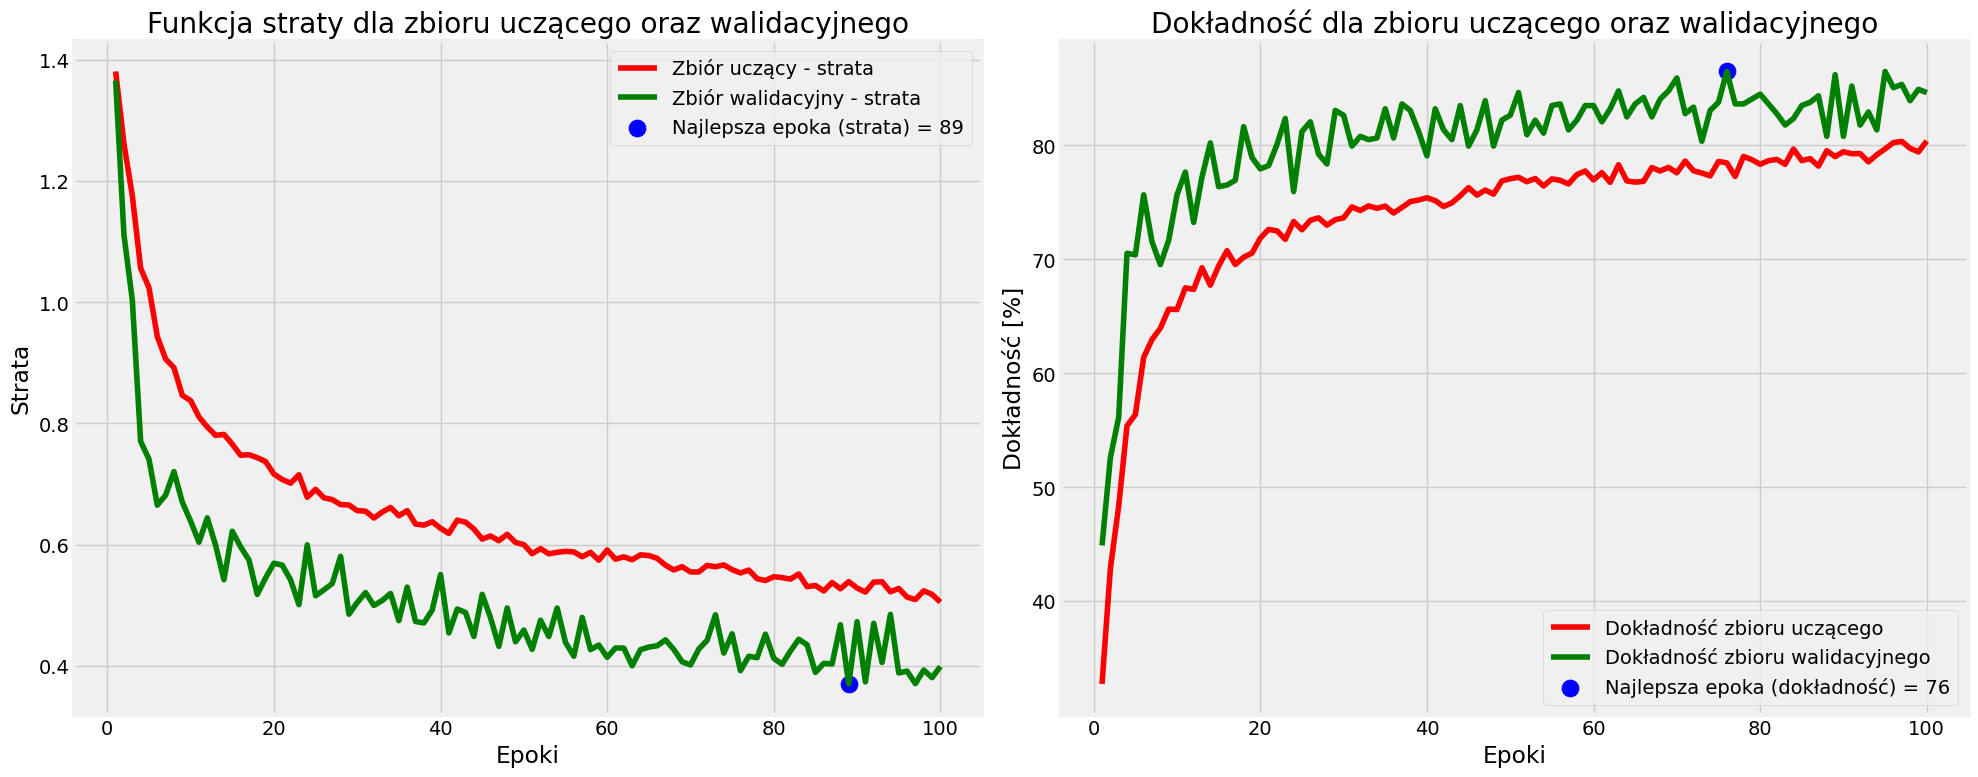

In [35]:
show_loss_accuracy_plots_with_timing(history)